In [32]:
# Initial imports.
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os

import sqlite3 
import sqlalchemy as db

import numpy as np
from config import db_password
import time

In [27]:
from sqlalchemy import create_engine

# Add the code to create the connection to the PostgreSQL database, then add the movies_df DataFrame to a SQL database:
# db_string = f"postgres://postgresql://{db_password}@127.0.0.1:5433/movie_data"
hostname = "bootcamp-group-3.cn5djhczpkaa.us-east-1.rds.amazonaws.com"
database = 'Bootcamp_Group_3'
connection_string = f"postgresql://root:{db_password}@{hostname}/{database}"

engine = create_engine(connection_string)

In [3]:
from sqlalchemy import inspect

In [4]:
insp = inspect(engine)
insp.get_table_names()

['Links',
 'Tags',
 'Movies',
 'Ratings',
 'Genome_Scores',
 'Genome_Tags',
 'tableau_database',
 'tableau_database_light',
 'tableau_database2',
 'tableau_dataset',
 'tableau_final']

In [5]:
movies = pd.read_sql('SELECT * from "Movies" ', engine)

In [6]:
movies.dtypes

movieId     int64
title      object
genres     object
year        int64
dtype: object

In [7]:
movies.nunique()

movieId    62423
title      58577
genres      1639
year         136
dtype: int64

In [8]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"Adventure, Animation, Children, Comedy, Fantasy",1995
1,2,Jumanji,"Adventure, Children, Fantasy",1995
2,3,Grumpier Old Men,"Comedy, Romance",1995
3,4,Waiting to Exhale,"Comedy, Drama, Romance",1995
4,5,Father of the Bride Part II,Comedy,1995


In [9]:
ratings = pd.read_sql('SELECT * from "Ratings" ', engine)

In [10]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object

In [11]:
ratings.nunique()

userId         162541
movieId         59047
rating             10
timestamp    20115267
dtype: int64

In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,157954,1198,5.0,2001-06-19 17:07:43
1,157954,1199,4.0,2001-06-19 17:46:44
2,157954,1200,5.0,2001-06-19 17:08:37
3,157954,1201,3.0,2001-06-19 17:09:36
4,157954,1204,3.0,2001-06-19 17:35:23


In [13]:
# Merge ratings and movie database
mergedratings_df = pd.merge(ratings,movies,on='movieId', how='left')

In [14]:
mergedratings_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,157954,1198,5.0,2001-06-19 17:07:43,Raiders of the Lost Ark (Indiana Jones and the...,"Action, Adventure",1981
1,157954,1199,4.0,2001-06-19 17:46:44,Brazil,"Fantasy, Sci-Fi",1985
2,157954,1200,5.0,2001-06-19 17:08:37,Aliens,"Action, Adventure, Horror, Sci-Fi",1986
3,157954,1201,3.0,2001-06-19 17:09:36,"Good, the Bad and the Ugly, The (Buono, il bru...","Action, Adventure, Western",1966
4,157954,1204,3.0,2001-06-19 17:35:23,Lawrence of Arabia,"Adventure, Drama, War",1962


In [15]:
mergedratings_df['timestamp']=pd.to_datetime(mergedratings_df['timestamp'],format='%Y-%m-%d %H:%M:%S.%f')

In [16]:
mergedratings_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,157954,1198,5.0,2001-06-19 17:07:43,Raiders of the Lost Ark (Indiana Jones and the...,"Action, Adventure",1981
1,157954,1199,4.0,2001-06-19 17:46:44,Brazil,"Fantasy, Sci-Fi",1985
2,157954,1200,5.0,2001-06-19 17:08:37,Aliens,"Action, Adventure, Horror, Sci-Fi",1986
3,157954,1201,3.0,2001-06-19 17:09:36,"Good, the Bad and the Ugly, The (Buono, il bru...","Action, Adventure, Western",1966
4,157954,1204,3.0,2001-06-19 17:35:23,Lawrence of Arabia,"Adventure, Drama, War",1962


In [17]:
userratingcount=mergedratings_df.groupby(['userId']).count()
userratingcount.head()

,movieId,rating,timestamp,title,genres,year
userId,,,,,,
1,70,70,70,70,70,70
2,184,184,184,184,184,184
3,656,656,656,656,656,656
4,242,242,242,242,242,242
5,101,101,101,101,101,101


In [18]:
bins = [1 , 20, 100, 250, 500, 1000,100000]
numberofratingsperuser= userratingcount.groupby(['movieId']).count()
numberofratingsperuser.head()

,rating,timestamp,title,genres,year
movieId,,,,,
20,4611,4611,4611,4611,4611
21,3406,3406,3406,3406,3406
22,3112,3112,3112,3112,3112
23,2916,2916,2916,2916,2916
24,2599,2599,2599,2599,2599


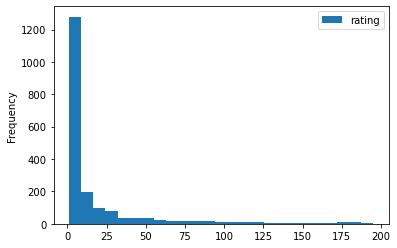

In [19]:
ax = numberofratingsperuser.iloc[:,0:1].loc[numberofratingsperuser.rating<200].plot.hist(bins=25)

In [20]:
#Filter out movies who have rated less than 100 movies 
filteredratings_df = mergedratings_df.groupby('userId').filter(lambda x: len(x)>100)

In [21]:
filteredratings_df.shape

(20316209, 7)

In [22]:
filteredratings_df = filteredratings_df.groupby('movieId').filter(lambda x: len(x)>100)

In [23]:
filteredratings_df.shape

(19761870, 7)

In [24]:
#Check sparsity of matrix
numratings = len(filteredratings_df['rating'])
numusers = len(filteredratings_df['userId'].unique())
numitems = len(filteredratings_df['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9688941762526184

In [25]:
#remove the space between words in genre column
filteredratings_df['genres'] = filteredratings_df['genres'].str.replace(' ','')
filteredratings_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,157954,1198,5.0,2001-06-19 17:07:43,Raiders of the Lost Ark (Indiana Jones and the...,"Action,Adventure",1981
1,157954,1199,4.0,2001-06-19 17:46:44,Brazil,"Fantasy,Sci-Fi",1985
2,157954,1200,5.0,2001-06-19 17:08:37,Aliens,"Action,Adventure,Horror,Sci-Fi",1986
3,157954,1201,3.0,2001-06-19 17:09:36,"Good, the Bad and the Ugly, The (Buono, il bru...","Action,Adventure,Western",1966
4,157954,1204,3.0,2001-06-19 17:35:23,Lawrence of Arabia,"Adventure,Drama,War",1962


In [26]:
# Create genre labels
genrelabels = set()
for i in filteredratings_df['genres'].str.split(',').values:
    genrelabels = genrelabels.union(set(i))

genrelabels

{'(nogenreslisted)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [28]:
 cleanratings=filteredratings_df.drop(['timestamp','title','genres','year'],axis=1)
 cleanratings.head()

,userId,movieId,rating
0,157954,1198,5.0
1,157954,1199,4.0
2,157954,1200,5.0
3,157954,1201,3.0
4,157954,1204,3.0


In [29]:
#export cleaned csv for import into Postgres
cleanratings.to_csv('../clean_data_tables/cleanratings.csv', index=False)

In [34]:
#load cleanratings table into SQL

# chunk csv data, print rows being exported, run timer
rows_imported = 0
start_time = time.time()
for data in pd.read_csv('../clean_data_tables/cleanratings.csv', chunksize=1000000):

    print(f'importing rows {rows_imported} to {rows_imported + len(data)}...', end='')  
    data.to_sql(name='Model_Refined_Data', con=engine, if_exists='append')
    rows_imported += len(data)
    
    print(f'Done. {time.time() - start_time} total seconds elapsed')

importing rows 0 to 1000000...Done. 63.49744462966919 total seconds elapsed
importing rows 1000000 to 2000000...Done. 128.67687034606934 total seconds elapsed
importing rows 2000000 to 3000000...Done. 193.32205772399902 total seconds elapsed
importing rows 3000000 to 4000000...Done. 257.90518617630005 total seconds elapsed
importing rows 4000000 to 5000000...Done. 322.13034653663635 total seconds elapsed
importing rows 5000000 to 6000000...Done. 386.3369960784912 total seconds elapsed
importing rows 6000000 to 7000000...Done. 451.69865441322327 total seconds elapsed
importing rows 7000000 to 8000000...Done. 516.9866800308228 total seconds elapsed
importing rows 8000000 to 9000000...Done. 582.9434525966644 total seconds elapsed
importing rows 9000000 to 10000000...Done. 648.6742398738861 total seconds elapsed
importing rows 10000000 to 11000000...Done. 713.5738348960876 total seconds elapsed
importing rows 11000000 to 12000000...Done. 778.9942197799683 total seconds elapsed
importing ro